In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Modules

In [ ]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, GRU, LayerNormalization, Conv1D, MaxPooling1D, Flatten, Input, MultiHeadAttention, Attention, LayerNormalization, Add, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import Model
import pickle

# Data Loading

In [ ]:
directory = '/content/drive/MyDrive/ECG CSV file/'
all_files = glob.glob(os.path.join(directory, "*.csv")) # Load all CSV files using glob
dfs = [] # Initialize list to store dataframes

# Loop through and read each CSV file
for filename in all_files:
  df = pd.read_csv(filename)

  # Clean the dataframe
  df.columns = df.columns.str.strip("'")
  df = df.apply(lambda x: x.str.strip("'") if x.dtype == "object" else x)
  df['Time and date'] = pd.to_datetime(df['Time and date'].str.extract(r'\[(.*?)\]')[0], format='%H:%M:%S.%f %d/%m/%Y')

  # Convert ECG columns to numeric
  for col in ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']:
      df[col] = pd.to_numeric(df[col], errors='coerce')

  # Drop rows with missing values
  df.dropna(inplace=True)

  # Append to the list of dataframes
  dfs.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

# Signal Processing (Filtering and ICA)

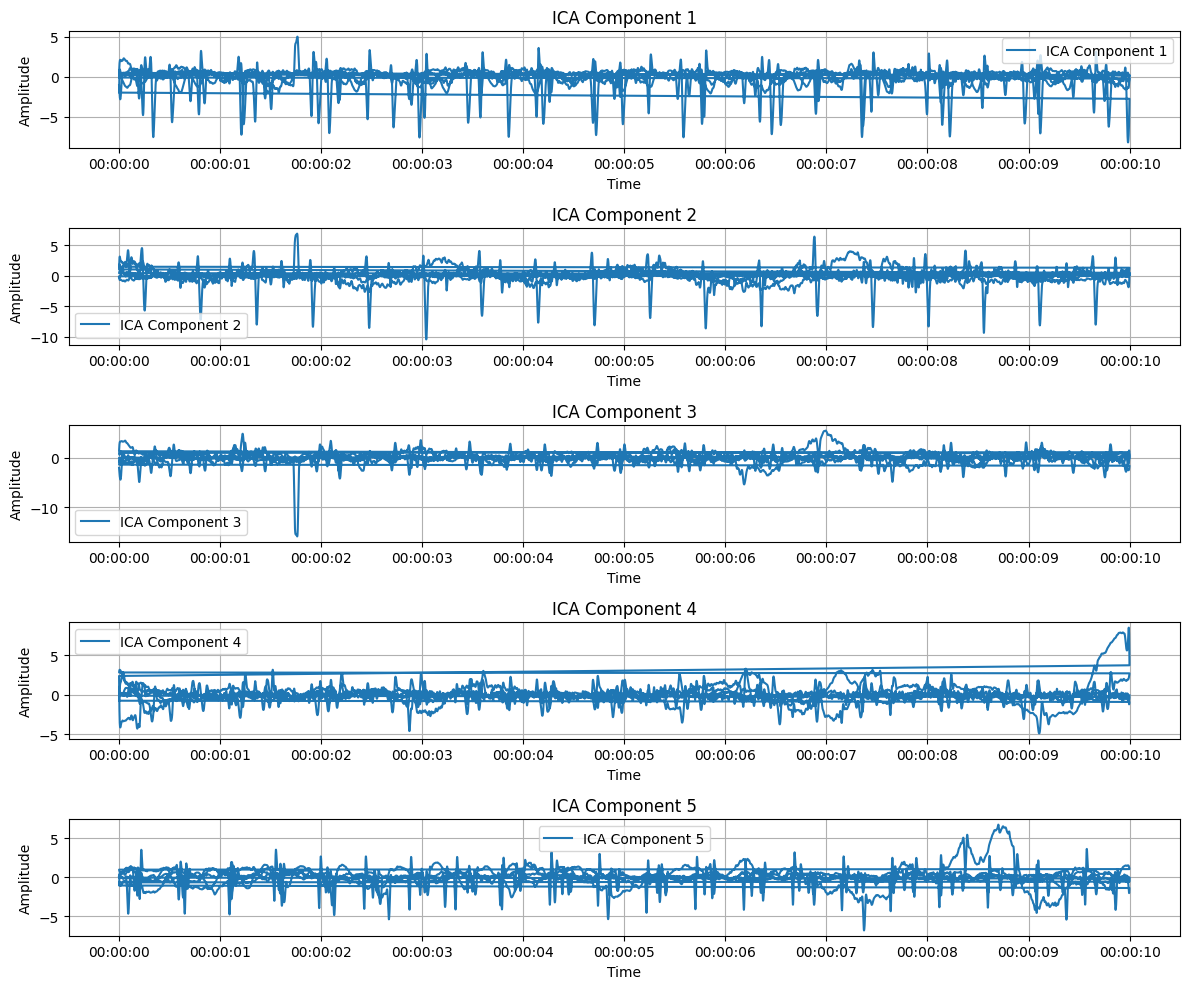

In [ ]:
# Bandpass filter function (0.5–50 Hz)
def bandpass_filter(signal, lowcut=0.5, highcut=50.0, fs=1000, order=2):
  nyq = 0.5 * fs  # Nyquist Frequency
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  filtered_signal = filtfilt(b, a, signal)
  return filtered_signal

# Apply filter to all ECG columns
signals = combined_df[['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']]
filtered_signals = signals.apply(lambda col: bandpass_filter(col))

# Apply ICA to the filtered signals
ica = FastICA(n_components=5, random_state=42)
ica_sources = ica.fit_transform(filtered_signals)  # Decomposed signals

# Plot the independent components
plt.figure(figsize=(12, 10))
for i in range(5):
  plt.subplot(5, 1, i+1)
  plt.plot(combined_df['Time and date'], ica_sources[:, i], label=f'ICA Component {i+1}')
  plt.title(f'ICA Component {i+1}')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.grid(True)
  plt.legend()
plt.tight_layout()
plt.show()

# Assume Component 2 represents fetal ECG
fetal_ecg_signal = ica_sources[:, 1]

# R-Peak Detection

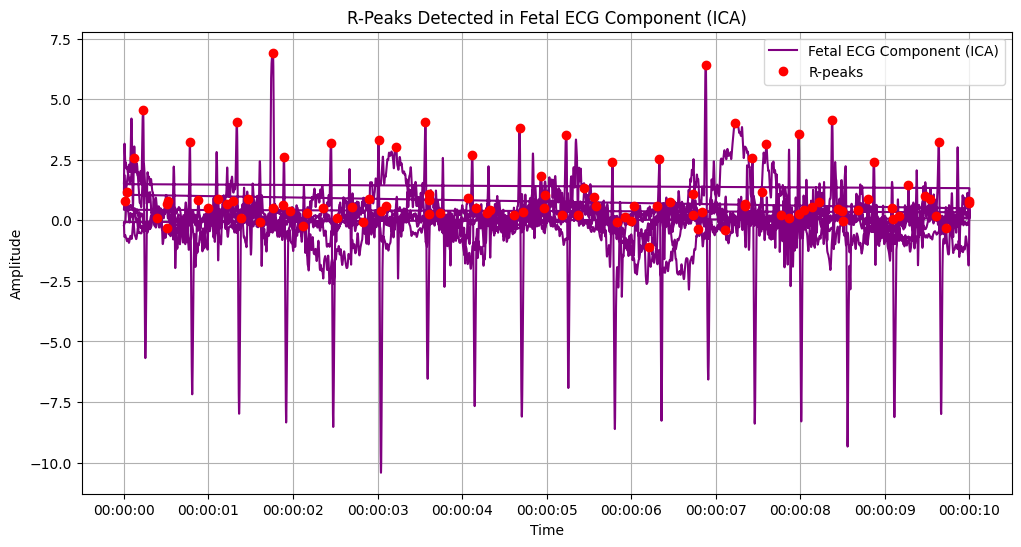

In [ ]:
# Detect R-peaks in the fetal ECG component
peaks, _ = find_peaks(fetal_ecg_signal, distance=350)

# Plot the R-peaks on the fetal ECG component
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Time and date'], fetal_ecg_signal, label='Fetal ECG Component (ICA)', color='purple')
plt.plot(combined_df['Time and date'].iloc[peaks], fetal_ecg_signal[peaks], 'ro', label='R-peaks')
plt.title('R-Peaks Detected in Fetal ECG Component (ICA)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# FHR/MHR Processing

In [ ]:
# Function for FHR/MHR Delay Compensation
# Adjust the delay value(if applicable)
def delay_compensation(peaks, delay=0):
  compensated_peaks = peaks + delay
  return compensated_peaks

# Detect false signals based on heart rate thresholds
def detect_false_signals(signal, combined_df, peaks, min_hr=60, max_hr=180):
  rr_intervals = np.diff(combined_df['Time and date'].iloc[peaks].values).astype('timedelta64[s]').astype(float)
  valid_rr_intervals = rr_intervals[rr_intervals > 0]
  hr = 60 / valid_rr_intervals
  false_signal_mask = (hr < min_hr) | (hr > max_hr)
  false_signals = np.zeros(len(peaks), dtype=bool)
  false_signals[1:1+len(false_signal_mask)] = false_signal_mask
  return false_signals

false_signals = detect_false_signals(fetal_ecg_signal, combined_df, peaks)
if np.any(false_signals):
  print("False signals detected at the following indices:", peaks[false_signals])
else:
  print("No false signals detected.")

# Detect hold periods where the signal remains constant
def detect_hold_periods(signal, threshold=0.1):
  hold_periods = []
  start = None
  for i in range(1, len(signal)):
    if abs(signal[i] - signal[i-1]) < threshold:
        if start is None:
            start = i - 1
    else:
      if start is not None:
        hold_periods.append((start, i - 1))
        start = None
  return hold_periods

hold_periods = detect_hold_periods(fetal_ecg_signal)

No false signals detected.


# Heart Rate Calculation

Average RR Interval: 0.10 seconds


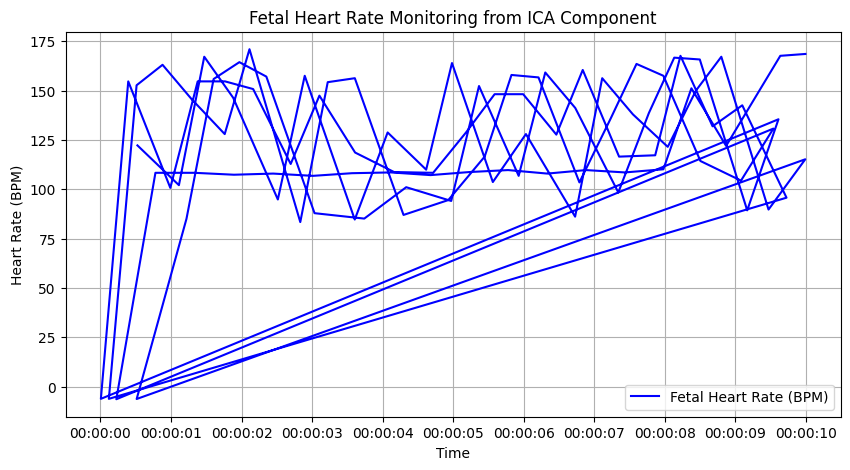

In [ ]:
# Calculate RR intervals and heart rate
rr_intervals = combined_df['Time and date'].iloc[peaks].diff().dt.total_seconds().dropna()
average_rr_interval = rr_intervals.mean()
print(f"Average RR Interval: {average_rr_interval:.2f} seconds")
heart_rate = 60 / rr_intervals

# Plot the heart rate over time
plt.figure(figsize=(10, 5))
plt.plot(combined_df['Time and date'].iloc[peaks][1:], heart_rate, label='Fetal Heart Rate (BPM)', color='blue')
plt.title('Fetal Heart Rate Monitoring from ICA Component')
plt.xlabel('Time')
plt.ylabel('Heart Rate (BPM)')
plt.grid(True)
plt.legend()
plt.show()

# Data Augumentation

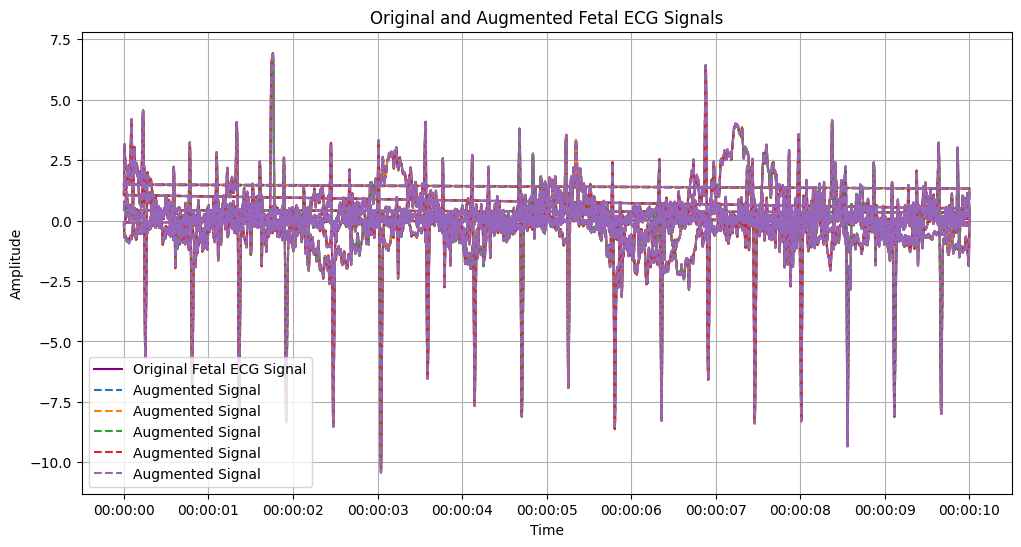

In [ ]:
# Function for augmenting data by adding noise
def augment_data(signal, num_augmentations=5, noise_level=0.01):
    augmented_signals = []
    for _ in range(num_augmentations):
        noise = np.random.normal(0, noise_level, signal.shape)
        augmented_signal = signal + noise
        augmented_signals.append(augmented_signal)
    return augmented_signals

# Generate augmented data
augmented_fetal_ecg_signals = augment_data(fetal_ecg_signal)

# Plot original and augmented signals
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Time and date'], fetal_ecg_signal, label='Original Fetal ECG Signal', color='purple')
for aug_signal in augmented_fetal_ecg_signals:
    plt.plot(combined_df['Time and date'], aug_signal, label='Augmented Signal', linestyle='--')
plt.title('Original and Augmented Fetal ECG Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# Heart Rate Calculation

                                    Time  RR_Interval         BPM
Signal_Index Row                                                 
0            0   2011-01-01 00:00:00.523        0.490  122.448980
             1   2011-01-01 00:00:01.112        0.589  101.867572
             2   2011-01-01 00:00:01.471        0.359  167.130919
             3   2011-01-01 00:00:01.881        0.410  146.341463
             4   2011-01-01 00:00:02.541        0.660   90.909091


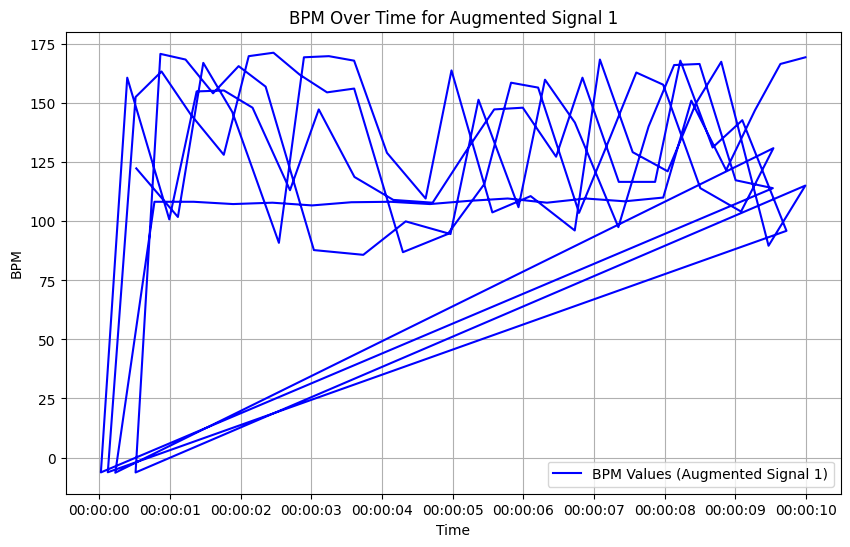

In [ ]:
time_values = combined_df['Time and date']

def calculate_r_peaks_bpm(signal, time_values, distance=350, sampling_rate=1000):
  peaks, _ = find_peaks(signal, distance=distance) # Detect R-peaks
  # Calculate RR intervals
  peak_times = pd.to_datetime(time_values.iloc[peaks].values)  # Ensure time values are datetime
  rr_intervals = np.diff(peak_times).astype('timedelta64[ms]').astype(float) / 1000  # Convert to seconds
  rr_intervals = np.where(rr_intervals == 0, np.nan, rr_intervals) # Replace zero intervals with NaN to avoid division by zero
  bpm_values = 60 / rr_intervals # Calculate BPM (60 / RR interval)
  return peaks, rr_intervals, bpm_values


# Loop through each augmented signal
results = []
for idx, augmented_signal in enumerate(augmented_fetal_ecg_signals):
  # Calculate R-peaks, RR intervals, and BPM
  peaks, rr_intervals, bpm_values = calculate_r_peaks_bpm(
      signal=augmented_signal,
      time_values=time_values,
      distance=350,  # Adjust if needed for your sampling rate
      sampling_rate=1000  # Change if your sampling rate differs
  )
  # Store results in a dataframe
  results.append(pd.DataFrame({
      'Time': time_values.iloc[peaks].iloc[1:].reset_index(drop=True),  # Exclude first peak for RR intervals
      'RR_Interval': rr_intervals,
      'BPM': bpm_values
  }))

# Combine results into a single dataframe for all augmented signals
combined_results = pd.concat(results, keys=range(len(results)), names=['Signal_Index', 'Row'])

# Display the first few rows of the results
print(combined_results.head())

# Plot BPM values for the first augmented signal as an example
plt.figure(figsize=(10, 6))
plt.plot(combined_results.loc[0, 'Time'], combined_results.loc[0, 'BPM'], label='BPM Values (Augmented Signal 1)', color='blue')
plt.title('BPM Over Time for Augmented Signal 1')
plt.xlabel('Time')
plt.ylabel('BPM')
plt.grid(True)
plt.legend()
plt.show()

# BPM Classification

In [ ]:
def classify_heart_rate(hr):
    if 110 <= hr <= 160:
        return 'Normal Heart Rate'
    elif hr < 110:
        return 'Bradycardia'
    elif hr > 160:
        return 'Tachycardia'
    else:
        return 'Unknown'  # Unclassified cases

# Dataset preparation

In [ ]:
sequence_length = 10  # Number of time steps in each input sequence
X, y = [], [] # Initialize lists to store sequences and targets
scaler = MinMaxScaler() # Initialize MinMaxScaler

# Extract BPM values for normalization
bpm_all_values = combined_results['BPM'].dropna().values.reshape(-1, 1)  # Drop NaN values and reshape for scaler
# Fit and transform the scaler on the BPM values
bpm_all_values_scaled = scaler.fit_transform(bpm_all_values)

# Iterate over each signal
for signal_idx in range(combined_results.index.levels[0].max() + 1):
  # Extract scaled BPM values for the signal
  bpm_values_scaled = bpm_all_values_scaled[combined_results.loc[signal_idx, 'BPM'].dropna().index]

  # Create sequences and targets
  for i in range(len(bpm_values_scaled) - sequence_length):
    # Sequence of scaled BPM values
    X.append(bpm_values_scaled[i:i + sequence_length])
    # Next scaled BPM value as target
    y.append(bpm_values_scaled[i + sequence_length])

# Convert to NumPy arrays
X = np.array(X)  # Shape: (num_samples, sequence_length, 1)
y = np.array(y)  # Shape: (num_samples, 1)

# Reshape X for LSTM input: (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))  # 1 feature (BPM)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print dataset shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (380, 10, 1)
X_test shape: (96, 10, 1)
y_train shape: (380, 1)
y_test shape: (96, 1)


# Utility Functions

In [ ]:
class util:
  def __init__(self, X_train, y_train, X_test, y_test, scaler):
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.scaler = scaler  # Store the scaler for inverse transformation

  def train_model(self, model, batch_size, reduce_lr, early_stopping, epochs=1000):
    history = model.fit(
        self.X_train, self.y_train,
        validation_data=(self.X_test, self.y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[reduce_lr, early_stopping]
    )
    return history

  def plot_graph(self, history):
    # Extract data from history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_mae = history.history['mae']
    val_mae = history.history['val_mae']

    # Create a figure with subplots
    plt.figure(figsize=(14, 8))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss (MSE)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Plot MAE
    plt.subplot(2, 1, 2)
    plt.plot(train_mae, label='Training MAE', color='green')
    plt.plot(val_mae, label='Validation MAE', color='red')
    plt.title('Training and Validation MAE', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

  def model_prediction(self, model):
    # Evaluate the model
    loss, mae = model.evaluate(self.X_test, self.y_test, verbose=1)
    print(f"Test Loss: {loss}")
    print(f"Test MAE: {mae}")

    # Predict BPM using test data
    y_pred = model.predict(self.X_test)
    y_pred_bpm = self.scaler.inverse_transform(y_pred)

    # Inverse transform the actual values
    y_test_bpm = self.scaler.inverse_transform(self.y_test)

    y_test = np.array(self.y_test)
    y_pred = model.predict(self.X_test)
    y_pred = np.array(y_pred)

    # Ensure y_test is binary
    threshold = 0.5  # Adjust based on your use case
    y_test_binary = (y_test >= threshold).astype(int)  # Convert y_test to binary if needed

    # Threshold the predictions
    y_pred_binary = (y_pred >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    precision = precision_score(y_test_binary, y_pred_binary)
    recall = recall_score(y_test_binary, y_pred_binary)
    f1 = f1_score(y_test_binary, y_pred_binary)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print()
    print("-"*80)
    print()
    # Print the converted BPM values for comparison
    print("Predicted BPM (original scale):", y_pred_bpm[-10:].flatten())
    print("Actual BPM (original scale):", y_test_bpm[-10:].flatten())

# LSTM Model

In [ ]:
# LSTM Model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=1e-4)

lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Model Summary
lstm_model.summary()

# Create ReduceLROnPlateau callback with more aggressive parameters
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,369 (509.25 KB)

 Trainable params: 129,921 (507.50 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 5.9069 - mae: 1.6122 - val_loss: 3.2059 - val_mae: 0.7513 - learning_rate: 1.0000e-04
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3990 - mae: 1.4882 - val_loss: 3.1874 - val_mae: 0.7459 - learning_rate: 1.0000e-04
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9795 - mae: 1.3228 - val_loss: 3.1711 - val_mae: 0.7422 - learning_rate: 1.0000e-04
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.5335 - mae: 1.2012 - val_loss: 3.1730 - val_mae: 0.7510 - learning_rate: 1.0000e-04
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.1509 - mae: 1.1073 - val_loss: 3.1573 - val_mae: 0.7483 - learning_rate: 1.0000e-04
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.0481 - mae: 1.0479 - val_loss: 3.1584 - val_mae: 0.7570 - learning_rate: 1.0000e-04
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.9445 - mae: 0.9607 - val_loss: 3.1966 - val_mae: 0.7890

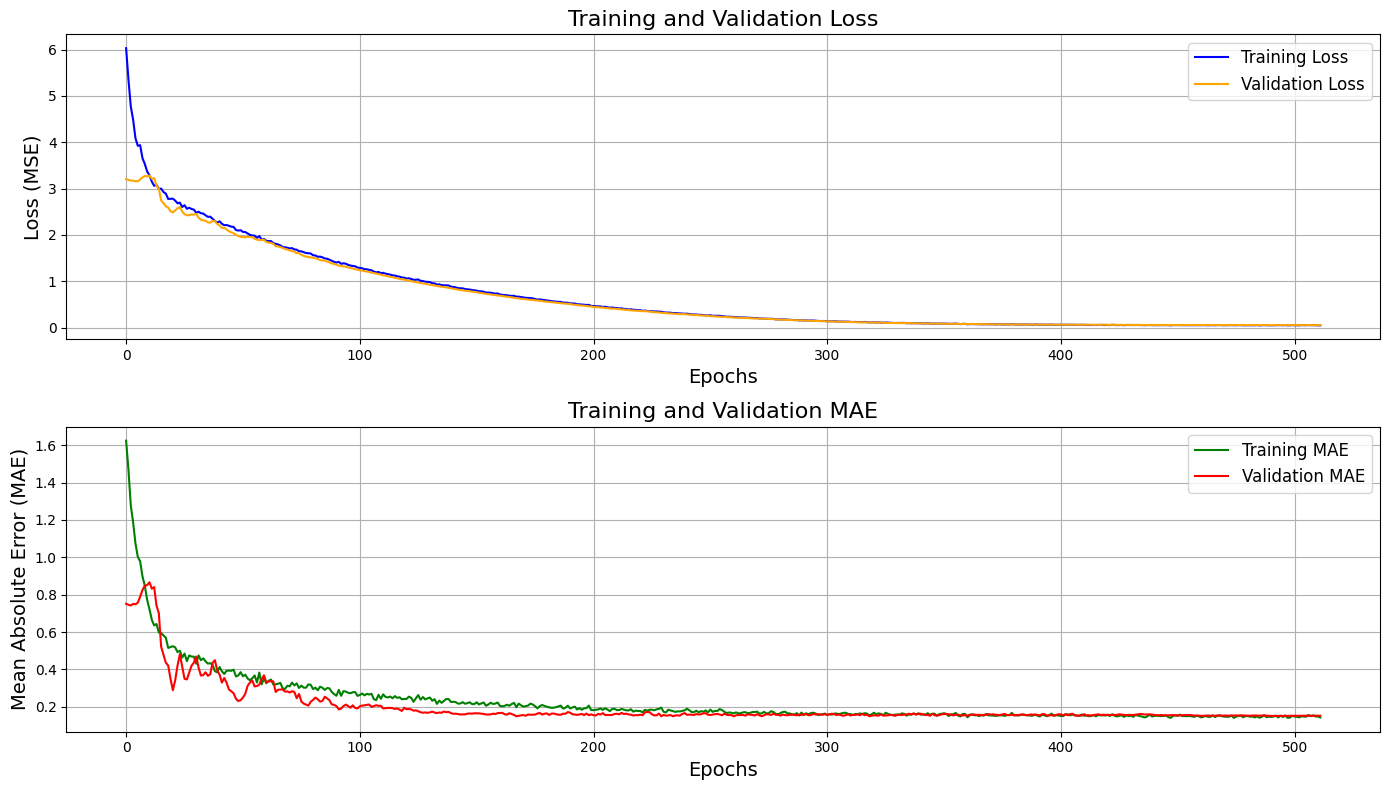

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0528 - mae: 0.1418 
Test Loss: 0.05627826228737831
Test MAE: 0.15107117593288422
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy: 0.9479
Precision: 0.9479
Recall: 1.0000
F1 Score: 0.9733
////////////////////////////////////////////////////////////////////////////////
Predicted BPM (original scale): [128.90344 141.94543 107.75914  90.70518 140.21368 126.46915  98.6473
 142.94612 140.60939 123.01643]
Actual BPM (original scale): [162.16216216 145.27845036 168.53932584 103.80622837 148.14814815
  85.83690987 106.76156584 163.48773842 157.06806283 147.05882353]


In [ ]:
Util = util(X_train, y_train, X_test, y_test, scaler)
history = Util.train_model(lstm_model, batch_size=16, reduce_lr=reduce_lr, early_stopping=early_stopping)
Util.plot_graph(history)
Util.model_prediction(lstm_model)

# GRU Model

In [ ]:
# GRU Model
gru_model = Sequential([
    GRU(128, return_sequences=True, kernel_regularizer=l2(0.02), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.35),
    GRU(64, return_sequences=True, kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.35),
    GRU(32, return_sequences=False, kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.35),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=1e-4)
gru_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Model Summary
gru_model.summary()

# Create ReduceLROnPlateau callback with more aggressive parameters
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 10, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 10, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,945 (386.50 KB)

 Trainable params: 98,497 (384.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 5.8619 - mae: 0.8865 - val_loss: 5.2341 - val_mae: 0.7749 - learning_rate: 1.0000e-04
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.6163 - mae: 0.8079 - val_loss: 5.1565 - val_mae: 0.7678 - learning_rate: 1.0000e-04
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.3416 - mae: 0.7159 - val_loss: 5.0568 - val_mae: 0.7455 - learning_rate: 1.0000e-04
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.2812 - mae: 0.7234 - val_loss: 4.9464 - val_mae: 0.7152 - learning_rate: 1.0000e-04
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.2964 - mae: 0.7449 - val_loss: 4.8655 - val_mae: 0.7047 - learning_rate: 1.0000e-04
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1322 - mae: 0.7458 - val_loss: 4.7637 - val_mae: 0.6802 - learning_rate: 1.0000e-04
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.0104 - mae: 0.7102 - val_loss: 4.6749 - val_mae: 0.6626

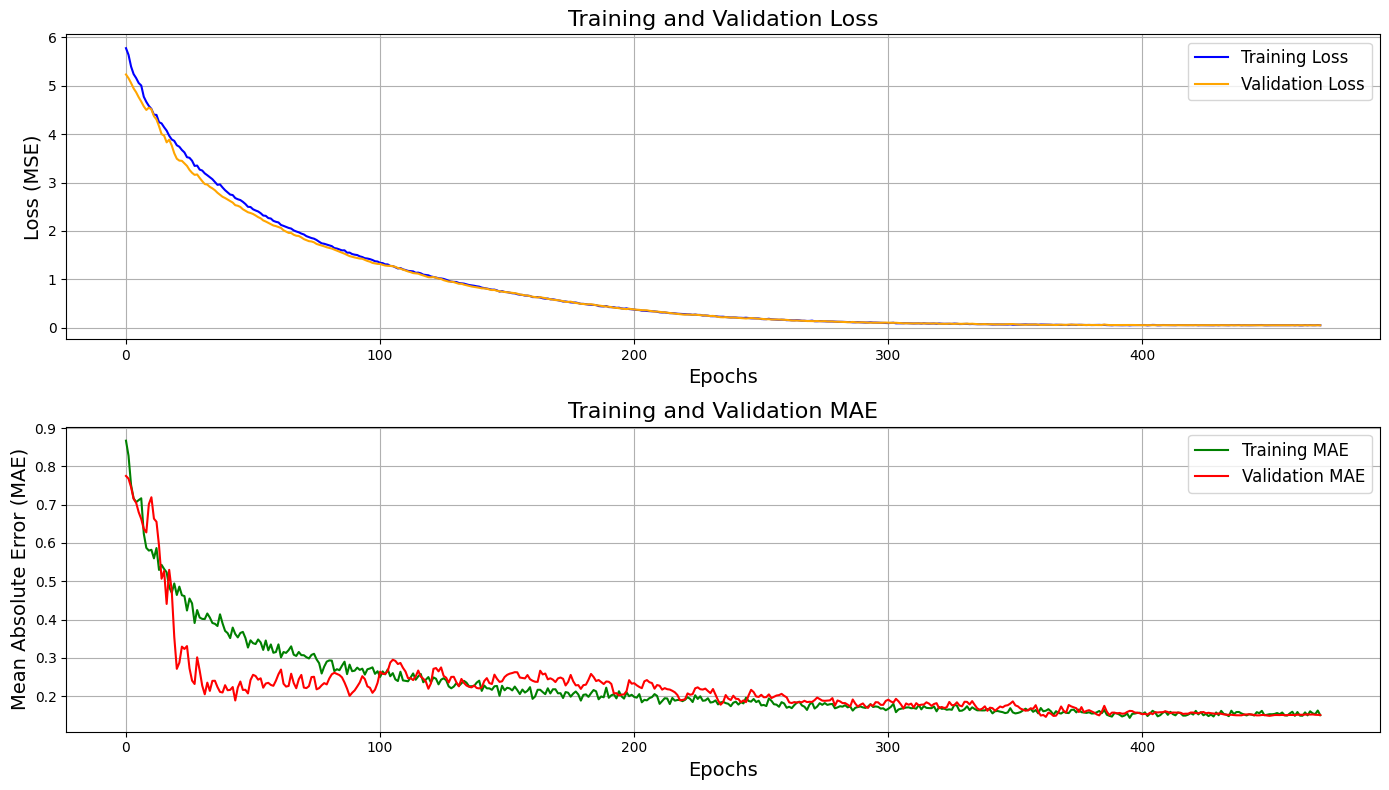

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0470 - mae: 0.1403 
Test Loss: 0.05099964141845703
Test MAE: 0.1485355645418167
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy: 0.9479
Precision: 0.9479
Recall: 1.0000
F1 Score: 0.9733

--------------------------------------------------------------------------------

Predicted BPM (original scale): [107.70063  129.04701  124.07875   93.045044 137.6169   106.79759
 105.097755 121.2043   137.00021  121.6407  ]
Actual BPM (original scale): [162.16216216 145.27845036 168.53932584 103.80622837 148.14814815
  85.83690987 106.76156584 163.48773842 157.06806283 147.05882353]


In [ ]:
Util = util(X_train, y_train, X_test, y_test, scaler)
history = Util.train_model(gru_model, batch_size=16, reduce_lr=reduce_lr, early_stopping=early_stopping)
Util.plot_graph(history)
Util.model_prediction(gru_model)

# Transformer Model

In [ ]:
# Define Transformer Block
def transformer_block(inputs, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    # Feed Forward Network
    ff_output = Dense(ff_dim, activation='relu', kernel_regularizer=l2(0.02))(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(inputs.shape[-1], kernel_regularizer=l2(0.02))(ff_output)
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

    return ff_output

# Model Input
input_shape = (X_train.shape[1], X_train.shape[2])  # Define input shape
inputs = Input(shape=input_shape)

# Transformer Blocks
x = transformer_block(inputs, num_heads=4, ff_dim=128, dropout_rate=0.1)
x = transformer_block(x, num_heads=4, ff_dim=128, dropout_rate=0.1)

# Final Layers
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1)(x)  # Output: Predicted BPM

# Model Definition
transformer_model = Model(inputs=inputs, outputs=x)

# Compile the model
optimizer = Adam(learning_rate=1e-4)
transformer_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Model Summary
transformer_model.summary()

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │         29 │ input_layer_9[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 10, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 1)     │          0 │ dropout_29[0][0], │
│                     │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 10, 128)   │        256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 10, 128)   │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 10, 1)     │        129 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 1)     │          0 │ dense_23[0][0],   │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │         29 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 10, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 10, 1)     │          0 │ dropout_32[0][0], │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 10, 128)   │        256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 10, 128)   │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 10, 1)     │        129 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 10, 1)     │          0 │ dense_25[0][0],   │
│                     │                   │            │ layer_normalizat

 Total params: 1,605 (6.27 KB)

 Trainable params: 1,605 (6.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - loss: 0.7477 - mae: 0.7408 - val_loss: 0.7219 - val_mae: 0.7217 - learning_rate: 1.0000e-04
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7496 - mae: 0.7473 - val_loss: 0.7134 - val_mae: 0.7196 - learning_rate: 1.0000e-04
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7232 - mae: 0.7270 - val_loss: 0.7051 - val_mae: 0.7174 - learning_rate: 1.0000e-04
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7120 - mae: 0.7237 - val_loss: 0.6970 - val_mae: 0.7153 - learning_rate: 1.0000e-04
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7229 - mae: 0.7385 - val_loss: 0.6890 - val_mae: 0.7132 - learning_rate: 1.0000e-04
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7242 - mae: 0.7422 - val_loss: 0.6811 - val_mae: 0.7110 - learning_rate: 1.0000e-04
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6959 - mae: 0.7216 - val_loss: 0.6735 - val_mae: 0.7089 - l

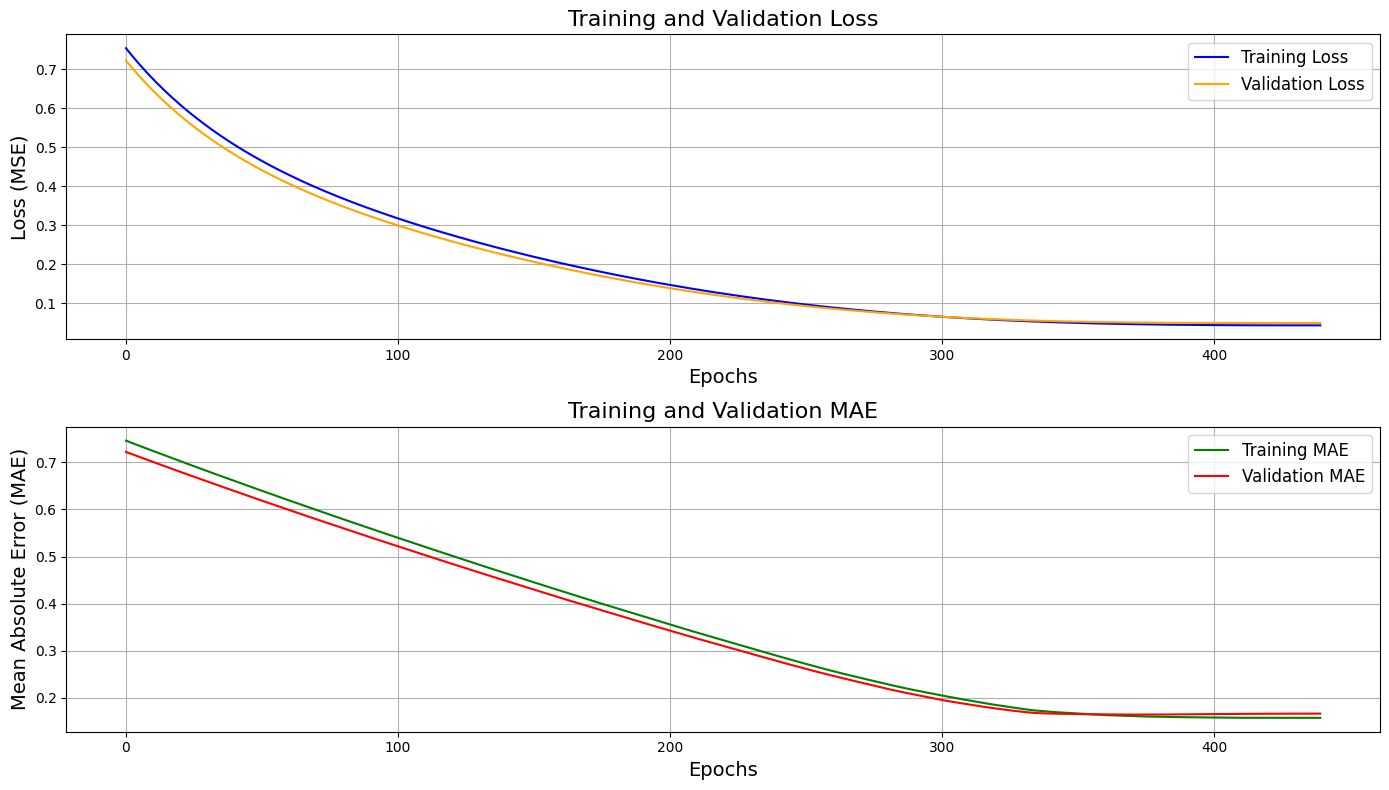

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0473 - mae: 0.1611
Test Loss: 0.04979875683784485
Test MAE: 0.16651028394699097
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy: 0.9479
Precision: 0.9479
Recall: 1.0000
F1 Score: 0.9733

--------------------------------------------------------------------------------

Predicted BPM (original scale): [122.29527 122.29527 122.29527 122.29527 122.29527 122.29527 122.29527
 122.29527 122.29527 122.29527]
Actual BPM (original scale): [162.16216216 145.27845036 168.53932584 103.80622837 148.14814815
  85.83690987 106.76156584 163.48773842 157.06806283 147.05882353]


In [ ]:
Util = util(X_train, y_train, X_test, y_test, scaler)
history = Util.train_model(transformer_model, batch_size=16, reduce_lr=reduce_lr, early_stopping=early_stopping)
Util.plot_graph(history)
Util.model_prediction(transformer_model)

# GRU-CNN Hybrid Model

In [ ]:
# GRU-CNN Model
gc_hybrid = Sequential([
    # CNN Layer
    Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.02), input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.35),

    # GRU Layer
    GRU(128, return_sequences=True, kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.35),

    # Another GRU Layer
    GRU(64, return_sequences=True, kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.35),

    # Final GRU Layer
    GRU(32, return_sequences=False, kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.35),

    # Dense Layers
    Dense(32, activation='relu'),
    Dense(1)
])

# Optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the model
gc_hybrid.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Model Summary
gc_hybrid.summary()

# Create ReduceLROnPlateau callback with more aggressive parameters
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 4, 128)         │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 4, 64)          │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,649 (483.00 KB)

 Trainable params: 123,073 (480.75 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 8.0379 - mae: 0.8965 - val_loss: 7.1490 - val_mae: 0.6456 - learning_rate: 1.0000e-04
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.7024 - mae: 0.8140 - val_loss: 7.0447 - val_mae: 0.6444 - learning_rate: 1.0000e-04
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.6246 - mae: 0.8418 - val_loss: 6.9355 - val_mae: 0.6365 - learning_rate: 1.0000e-04
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3023 - mae: 0.7209 - val_loss: 6.8150 - val_mae: 0.6180 - learning_rate: 1.0000e-04
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.1087 - mae: 0.6704 - val_loss: 6.6922 - val_mae: 0.5955 - learning_rate: 1.0000e-04
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2434 - mae: 0.7711 - val_loss: 6.5800 - val_mae: 0.5784 - learning_rate: 1.0000e-04
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.9788 - mae: 0.7251 - val_loss: 6.4602 - val_mae: 0.5525

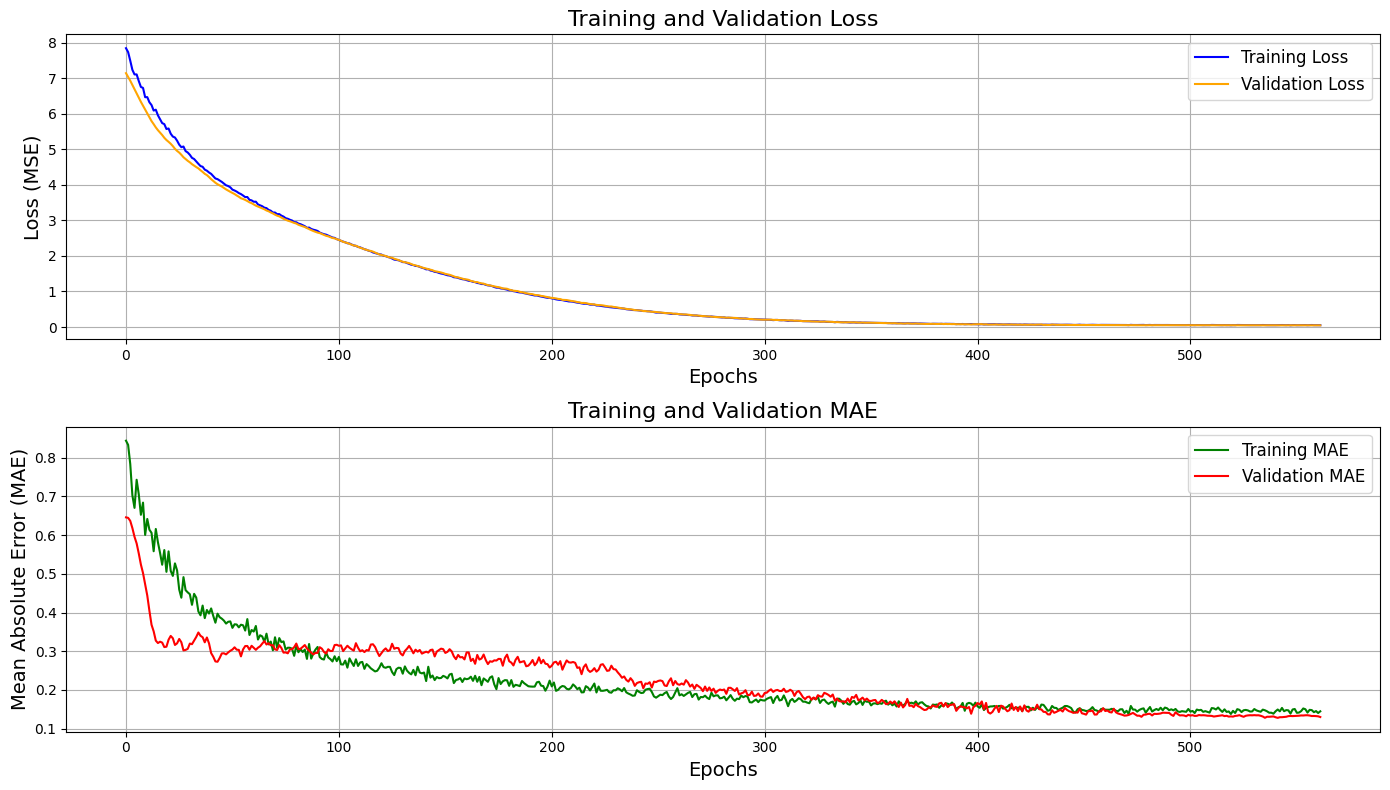

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0434 - mae: 0.1198 
Test Loss: 0.046116650104522705
Test MAE: 0.12806336581707
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

--------------------------------------------------------------------------------

Predicted BPM (original scale): [143.2383   132.63596  132.14323  109.06044  128.35977  113.02791
 110.980385 131.32834  129.08202  107.90618 ]
Actual BPM (original scale): [162.16216216 145.27845036 168.53932584 103.80622837 148.14814815
  85.83690987 106.76156584 163.48773842 157.06806283 147.05882353]


In [ ]:
Util = util(X_train, y_train, X_test, y_test, scaler)
history = Util.train_model(gc_hybrid, batch_size=16, reduce_lr=reduce_lr, early_stopping=early_stopping)
Util.plot_graph(history)
Util.model_prediction(gc_hybrid)

# LSTM-GRU Hybrid Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# LSTM-GRU Hybrid Model
lg_hybrid = Sequential([
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.02), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    GRU(64, return_sequences=True, kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.3),

    GRU(32, return_sequences=False, kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(1)
])

# Optimizer
optimizer = Adam(learning_rate=1e-4)
lg_hybrid.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Model Summary
lg_hybrid.summary()

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 10, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 10, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,201 (450.00 KB)

 Trainable params: 114,753 (448.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 5.7722 - mae: 0.9125 - val_loss: 5.0234 - val_mae: 0.6589 - learning_rate: 1.0000e-04
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.4605 - mae: 0.7716 - val_loss: 4.7715 - val_mae: 0.5251 - learning_rate: 1.0000e-04
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3848 - mae: 0.8124 - val_loss: 4.6080 - val_mae: 0.4405 - learning_rate: 1.0000e-04
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.1713 - mae: 0.7404 - val_loss: 4.4905 - val_mae: 0.3919 - learning_rate: 1.0000e-04
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.8831 - mae: 0.6065 - val_loss: 4.3913 - val_mae: 0.3591 - learning_rate: 1.0000e-04
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8718 - mae: 0.6347 - val_loss: 4.2945 - val_mae: 0.3237 - learning_rate: 1.0000e-04
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.8032 - mae: 0.6519 - val_loss: 4.1994 - val_mae: 0.2832

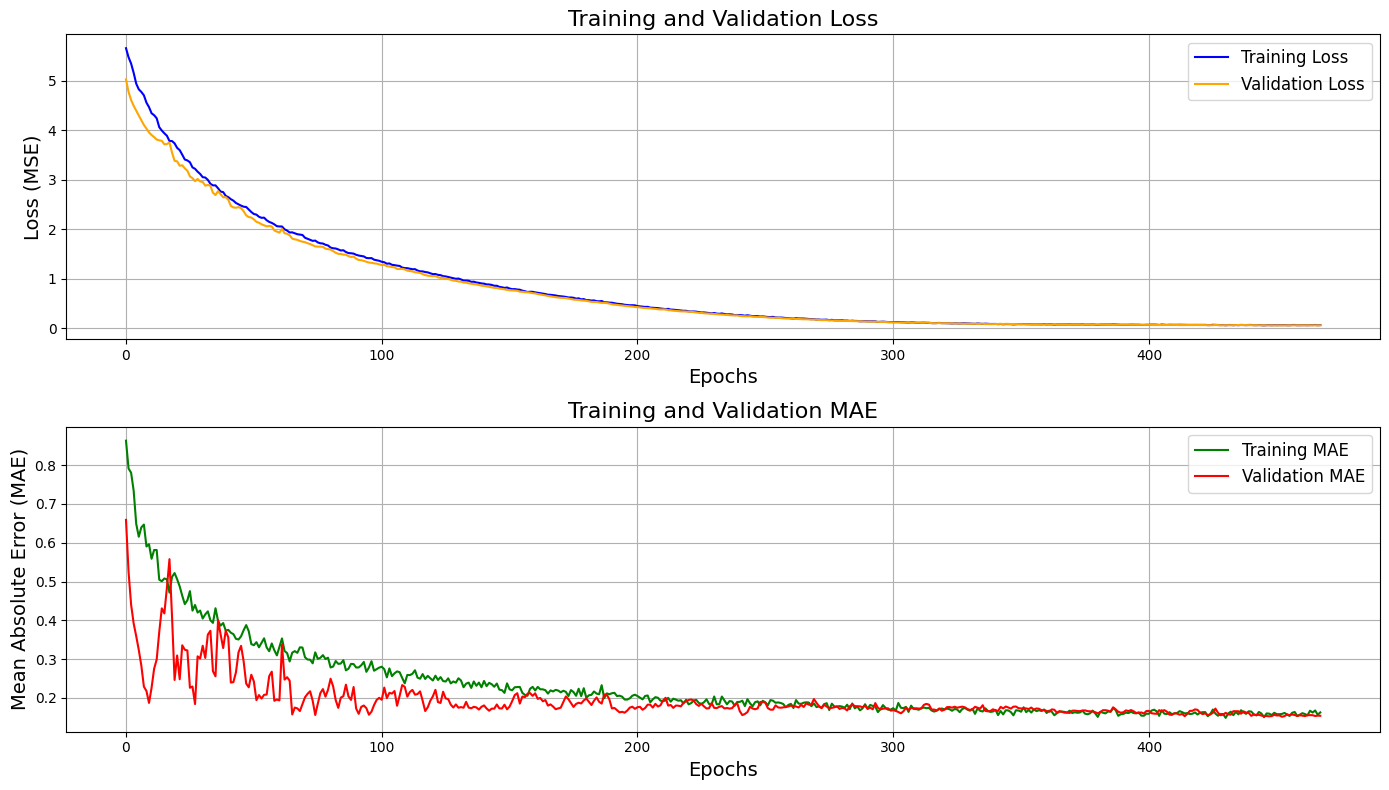

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0511 - mae: 0.1432 
Test Loss: 0.05477399751543999
Test MAE: 0.1524660885334015
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy: 0.9271
Precision: 0.9468
Recall: 0.9780
F1 Score: 0.9622

--------------------------------------------------------------------------------

Predicted BPM (original scale): [137.89088 131.26526 118.42638  84.52522 143.70616 111.20349  92.0228
 143.93942 146.07185 110.91202]
Actual BPM (original scale): [162.16216216 145.27845036 168.53932584 103.80622837 148.14814815
  85.83690987 106.76156584 163.48773842 157.06806283 147.05882353]


In [ ]:
Util = util(X_train, y_train, X_test, y_test, scaler)
history = Util.train_model(lg_hybrid, batch_size=16, reduce_lr=reduce_lr, early_stopping=early_stopping)
Util.plot_graph(history)
Util.model_prediction(lg_hybrid)

# Transformer-CNN Hybrid Model

In [ ]:
# Transformer block function
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed-forward layer
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

# Input layer
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN layers
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

# Transformer encoder
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

# Global pooling and dense layers
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
output = Dense(1)(x)  # Regression output

# Define and compile model
transformer_cnn_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=1e-4)
transformer_cnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Model summary
transformer_cnn_model.summary()

# Callbacks
reduce_lr_transformer_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
early_stopping_transformer_cnn = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 64)    │        256 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 5, 64)     │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5, 128)    │     24,704 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 128)    │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 2, 128)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 128)    │        256 │ max_pooling1d_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 128)    │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 2, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2, 128)    │          0 │ dropout_25[0][0], │
│                     │                   │            │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 128)    │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 2, 128)    │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 2, 128)    │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 2, 128)    │     16,512 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2, 128)    │          0 │ dense_19[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 128)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                 

 Total params: 199,553 (779.50 KB)

 Trainable params: 199,169 (778.00 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - loss: 1.7898 - mae: 0.7840 - val_loss: 1.2707 - val_mae: 0.6094 - learning_rate: 1.0000e-04
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.4460 - mae: 0.5967 - val_loss: 1.7067 - val_mae: 0.8795 - learning_rate: 1.0000e-04
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2934 - mae: 0.5331 - val_loss: 1.5066 - val_mae: 0.7684 - learning_rate: 1.0000e-04
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2963 - mae: 0.5288 - val_loss: 1.3612 - val_mae: 0.6838 - learning_rate: 1.0000e-04
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1976 - mae: 0.4605 - val_loss: 1.2755 - val_mae: 0.6313 - learning_rate: 1.0000e-04
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1858 - mae: 0.4623 - val_loss: 1.1611 - val_mae: 0.5428 - learning_rate: 1.0000e-04
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1540 - mae: 0.4427 - val_loss: 1.3379 - val_mae: 0.6775 - l

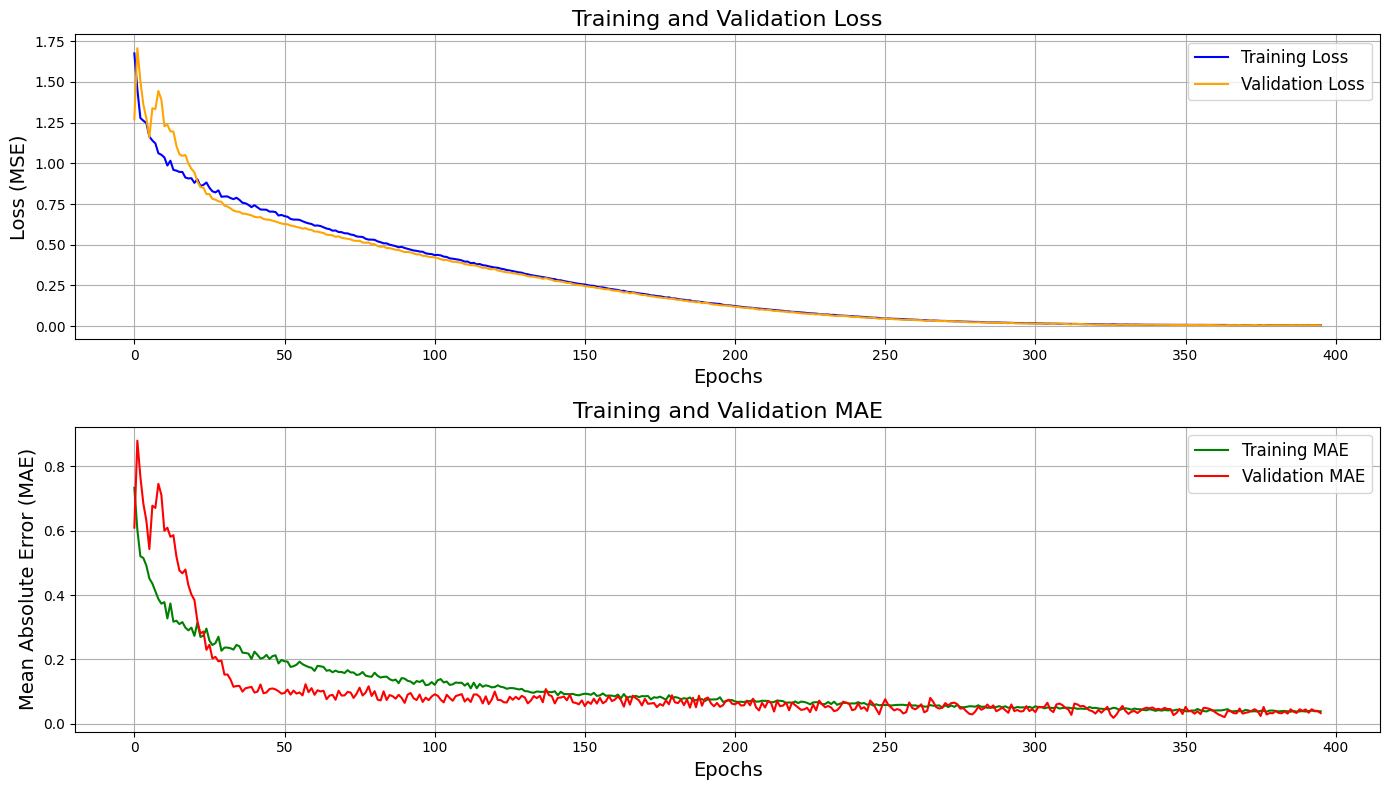

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0049 - mae: 0.0234
Test Loss: 0.005160121247172356
Test MAE: 0.024276167154312134
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

--------------------------------------------------------------------------------

Predicted BPM (original scale): [156.135   138.21959 166.63092 101.02931 144.45285  86.48733 103.58479
 162.64476 150.09782 139.40434]
Actual BPM (original scale): [162.16216216 145.27845036 168.53932584 103.80622837 148.14814815
  85.83690987 106.76156584 163.48773842 157.06806283 147.05882353]


In [ ]:
Util = util(X_train, y_train, X_test, y_test, scaler)
history = Util.train_model(transformer_cnn_model, batch_size=16, reduce_lr=reduce_lr, early_stopping=early_stopping)
Util.plot_graph(history)
Util.model_prediction(transformer_cnn_model)

# Attention Mechanism

In [ ]:
# Input shape from training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Input layer
inputs = Input(shape=input_shape)

# Bidirectional LSTM layer for richer context
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.02)))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Attention layer
attention = Attention()([x, x])  # Self-attention
x = LayerNormalization()(attention)

# Flatten before dense layers
x = Flatten()(x)

# Further processing
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(1)(x)

# Define model
attention_model = Model(inputs, outputs)

# Compile the model
optimizer = Adam(learning_rate=1e-4)
attention_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Model summary
attention_model.summary()

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 10, 128)   │     33,792 │ input_layer_4[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 128)   │        512 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 10, 128)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 10, 128)   │          0 │ dropout_12[0][0], │
│ (Attention)         │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ attention_2[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1280)      │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │    163,968 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │      2,080 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         33 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 208,897 (816.00 KB)

 Trainable params: 208,641 (815.00 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.1847 - mae: 1.1532 - val_loss: 1.3292 - val_mae: 1.0961 - learning_rate: 1.0000e-04
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8116 - mae: 0.6655 - val_loss: 1.1088 - val_mae: 0.9906 - learning_rate: 1.0000e-04
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7681 - mae: 0.6668 - val_loss: 0.9374 - val_mae: 0.9000 - learning_rate: 1.0000e-04
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5688 - mae: 0.5410 - val_loss: 0.8846 - val_mae: 0.8703 - learning_rate: 1.0000e-04
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4924 - mae: 0.5259 - val_loss: 0.6930 - val_mae: 0.7518 - learning_rate: 1.0000e-04
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4389 - mae: 0.4835 - val_loss: 0.5909 - val_mae: 0.6817 - learning_rate: 1.0000e-04
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4058 - mae: 0.4670 - val_loss: 0.4986 - val_mae: 0.6197

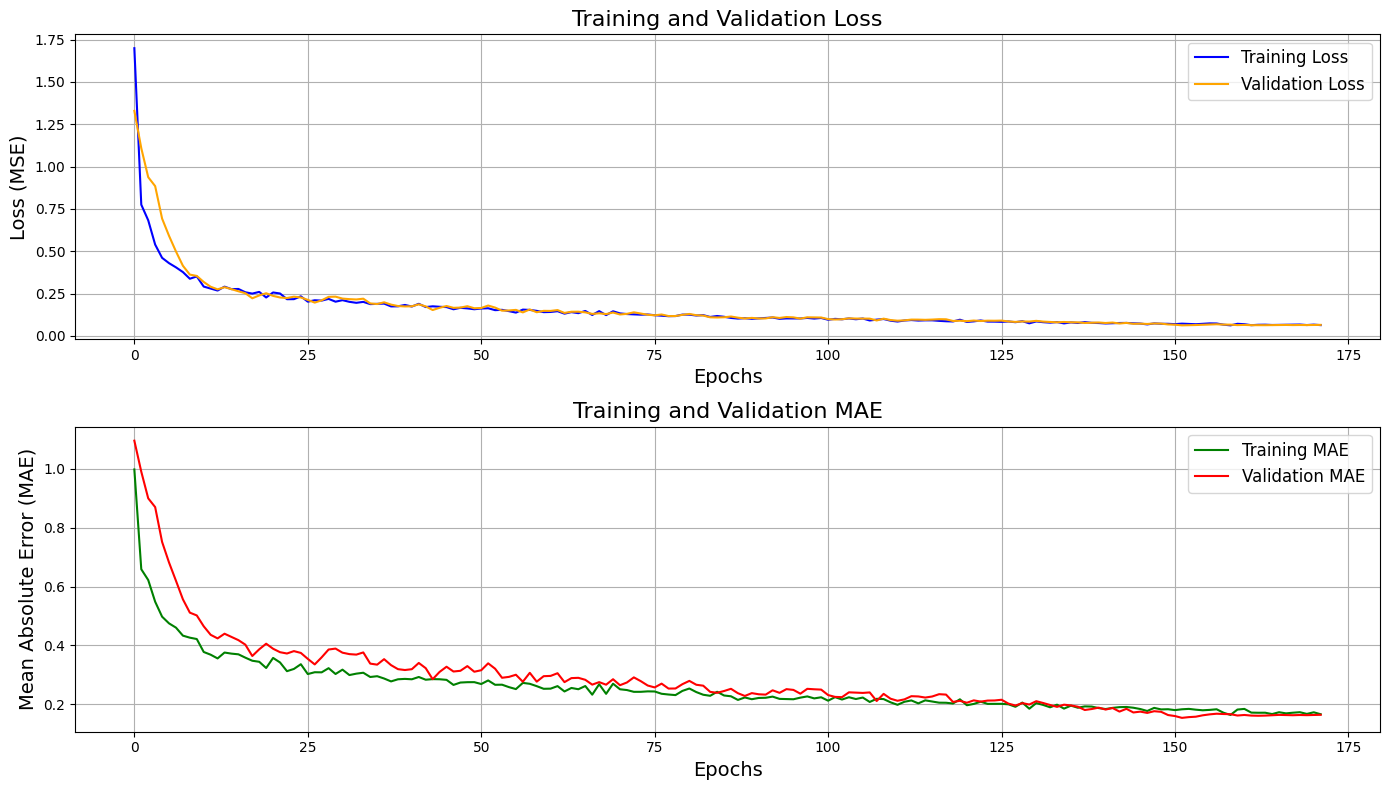

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0597 - mae: 0.1468 
Test Loss: 0.06213973090052605
Test MAE: 0.15350785851478577
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.9479
Precision: 0.9479
Recall: 1.0000
F1 Score: 0.9733

--------------------------------------------------------------------------------

Predicted BPM (original scale): [118.8061   119.34291  116.484245 109.97249  122.85995  110.34473
 109.74475  117.76367  125.53901  113.90067 ]
Actual BPM (original scale): [162.16216216 145.27845036 168.53932584 103.80622837 148.14814815
  85.83690987 106.76156584 163.48773842 157.06806283 147.05882353]


In [ ]:
Util = util(X_train, y_train, X_test, y_test, scaler)
history = Util.train_model(attention_model, batch_size=16, reduce_lr=reduce_lr, early_stopping=early_stopping)
Util.plot_graph(history)
Util.model_prediction(attention_model)

# GRU Model with Self Attention

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Bidirectional, Attention, Dense, Dropout, BatchNormalization, LayerNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Input shape from training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Input layer
inputs = Input(shape=input_shape)

# Bidirectional GRU layer for temporal context
x = Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2(0.02)))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Attention mechanism (self-attention)
attention = Attention()([x, x])
x = LayerNormalization()(attention)

# Flatten before dense layers
x = Flatten()(x)

# Fully connected layers with dropout
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(1)(x)

# Define the model
attention_gru_model = Model(inputs, outputs)

# Compile the model
optimizer = Adam(learning_rate=1e-4)
attention_gru_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Model summary
attention_gru_model.summary()

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 10, 256)   │    100,608 │ input_layer_12[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 256)   │      1,024 │ bidirectional_4[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 10, 256)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 10, 256)   │          0 │ dropout_43[0][0], │
│ (Attention)         │                   │            │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 256)   │        512 │ attention_4[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 2560)      │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 128)       │    327,808 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 128)       │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 64)        │      8,256 │ dropout_44[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 64)        │          0 │ dense_35[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 32)        │      2,080 │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 32)        │          0 │ dense_36[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 1)         │         33 │ dropout_46[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 440,321 (1.68 MB)

 Trainable params: 439,809 (1.68 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1.5955 - mae: 0.9831 - val_loss: 0.6373 - val_mae: 0.7145 - learning_rate: 1.0000e-04
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6002 - mae: 0.5870 - val_loss: 0.5656 - val_mae: 0.6690 - learning_rate: 1.0000e-04
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5912 - mae: 0.5589 - val_loss: 0.6484 - val_mae: 0.7223 - learning_rate: 1.0000e-04
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4041 - mae: 0.4610 - val_loss: 0.5453 - val_mae: 0.6558 - learning_rate: 1.0000e-04
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3944 - mae: 0.4646 - val_loss: 0.5062 - val_mae: 0.6288 - learning_rate: 1.0000e-04
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4241 - mae: 0.4730 - val_loss: 0.5086 - val_mae: 0.6317 - learning_rate: 1.0000e-04
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3548 - mae: 0.4263 - val_loss: 0.4042 - val_mae: 0.5475

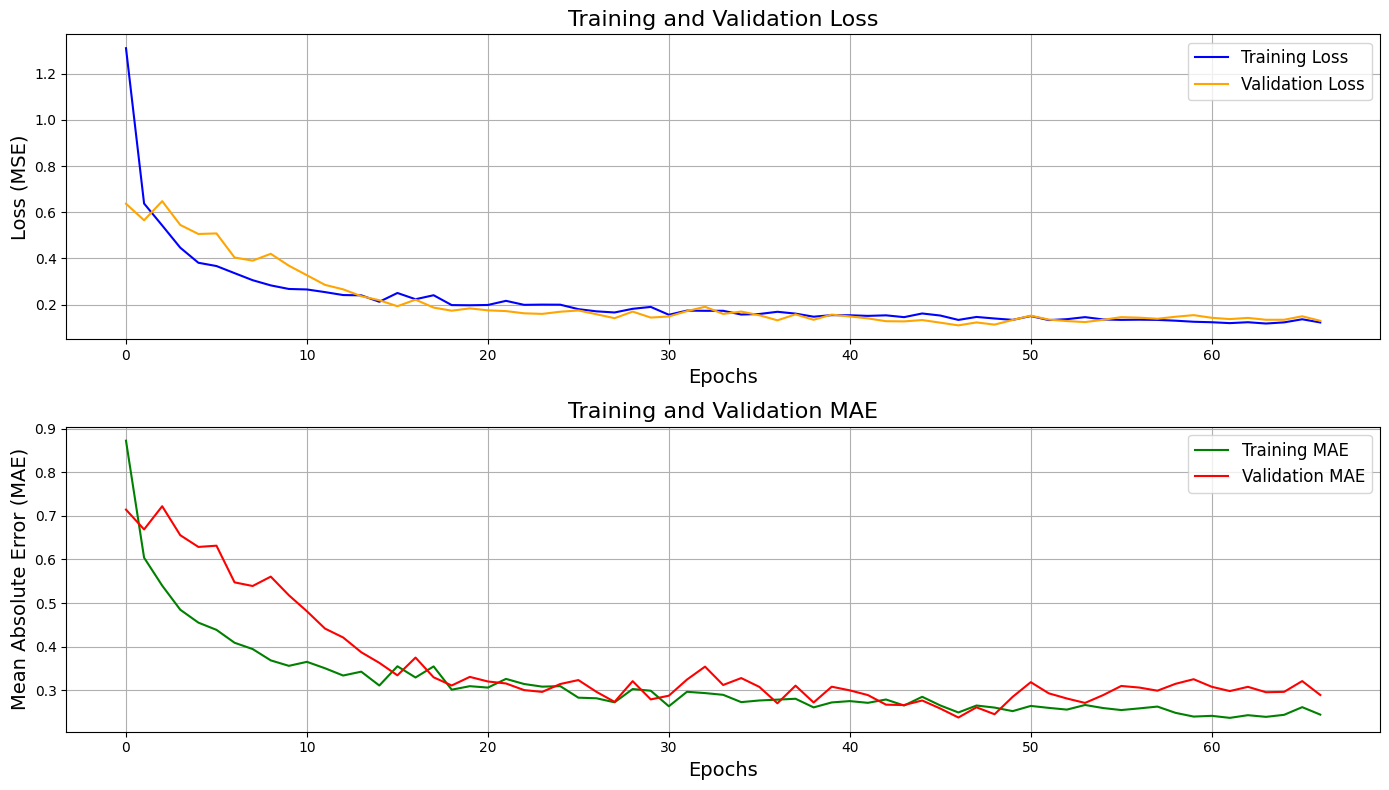

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1053 - mae: 0.2317 
Test Loss: 0.11029696464538574
Test MAE: 0.23713356256484985
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy: 0.6562
Precision: 1.0000
Recall: 0.6374
F1 Score: 0.7785

--------------------------------------------------------------------------------

Predicted BPM (original scale): [ 93.1059   103.60575   79.87108   87.0299   102.888794  82.94708
  67.50898   91.074486 121.26408  104.859924]
Actual BPM (original scale): [162.16216216 145.27845036 168.53932584 103.80622837 148.14814815
  85.83690987 106.76156584 163.48773842 157.06806283 147.05882353]


In [ ]:
Util = util(X_train, y_train, X_test, y_test, scaler)
history = Util.train_model(attention_gru_model, batch_size=16, reduce_lr=reduce_lr, early_stopping=early_stopping)
Util.plot_graph(history)
Util.model_prediction(attention_gru_model)